# MobileNets from Scratch in PyTorch (V1, V2, and V3)

MobileNet is a family of lightweight CNNs designed for mobile and embedded devices. The key idea is to reduce computation and model size using Depthwise Separable Convolutions instead of standard convolutions.

In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

In [4]:
def round_channels(channels, width_mult, divisor=8, min_value=None):
    """
    Round number of channels based on width multiplier (beta).
    Ensure that all layers have a channel number that is divisible by 'divisor'.
    - This helps with efficient hardware utilization.
    """
    if min_value is None:
        min_value= divisor

    new_channels= channels * width_mult
    new_channels= max(min_value, int(new_channels + divisor / 2) // divisor * divisor)
    # Prevent rounding down by more than 10%
    if new_channels < 0.9 * channels:
        new_channels += divisor

    return int(new_channels)


# Architecture Implementation

Starting by the fundamental building block of a CNN, represented by a convolutional layer.

Groups is specified to control how convolution is applied to input. If group=1, then a kernel is applied to all input channels and if group=in_channel (depthwise convolution), then a single convolutional kernel is applied for each input channel.

In [5]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    MobileNet-style: Input -> Conv2d -> BatchNorm2d -> ReLU -> Output
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1,
                 bias=False, norm=True, activation=None) -> None:
        super(ConvLayer, self).__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=bias
        )
        # Batch Normalization to stabilize training
        self.norm= nn.BatchNorm2d(out_channels) if norm else None
        # Activation function -- ReLU is the default in MobileNet
        self.activation= activation


    def forward(self, x):
        x= self.conv(x)
        if self.norm is not None:
            x= self.norm(x)
        if self.activation is not None:
            x= self.activation(x)

        return x


# MobileNetV1

Depthwise Separable Convolution is a lightweight and efficient convolutional neural network architecture. It decomposes the standard convolution process into two separate steps: depthwise convolution and pointwise convolution. The depthwise convolution applies a single convolutional filter for each input channel, while the pointwise convolution performs a 1x1 convolution to combine the filtered outputs. If you do your match, this approach is the same thing as doing a normal 3x3 conv but it significantly reduces the computational cost and model parameters, making it suitable for resource-constrained environments without sacrificing performance.

The first version of MobileNet, MobileNetV1, applies a non-linear activation after both the depthwise and the pointwise convolutions. In the original design, each convolutional operation is typically followed by a batch normalization and a ReLU activation (some experimental implementations might remove an activation after the depthwise convolution to study its effect on performancev).

https://arxiv.org/abs/1704.04861

In [6]:
class DepthwiseSeparableBlock(nn.Module):
    """
    Implements the depthwise separable convolution block from MobileNetV1.
    This block consists of a depthwise convolution (channel-wise 3x3 conv) followed by a
    pointwise convolution (1x1 conv) to combine the features across channels.
    Both stages include Batch Normalization followed by a non-linear activation.
    """

    def __init__(self, in_channels, out_channels, stride=1, activation=None) -> None:
        super(DepthwiseSeparableBlock, self).__init__()
        # Activation function -- ReLU is the default in MobileNet
        activation= nn.ReLU(inplace=True) if activation is None else activation
        # Depthwise convolution: group convolution with groups=in_channels
        self.depthwise= ConvLayer(
            in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels,
            bias=False, activation=activation
        )
        # Pointwise convolution: 1x1 convolution to mix features across channels
        self.pointwise= ConvLayer(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0,
            bias=False, activation=activation
        )


    def forward(self, x):
        x= self.depthwise(x)
        x= self.pointwise(x)

        return x


# Building the MobileNetV1 model

The MobileNet paper introduces the concept of a width multiplier to scale the number of channels (filters) at every layer. Common multipliers include:

- **1.0:** The full-size network, which is the default configuration in the paper.
- **0.75, 0.5, 0.35:** These smaller versions are provided to reduce the computational cost and the number of parameters, making the model more efficient for deployment on resource-constrained devices.

Although the original paper typically uses an **input resolution** of 224x224, some implementations vary the resolution to further trade off between accuracy and efficiency (e.g. 224, 192, 160, 128). The sequential feature extractor (self.features) is built using a series of DepthwiseSeparableBlock modules. Downsampling is achieved by setting stride=2 for certain blocks.

In [7]:
class MobileNetV1(nn.Module):
    """
    Implements the MobileNetV1 architecture.
    - An initial stem using a convolution layer to reduce spatial dimensions.
    - A sequence of depthwise separable convolution blocks.
    - Global average pooling and a fully connected classification head (if num_classes is provided).
    """

    def __init__(self, in_channels, num_classes=None, stem_channels=32, width_mult=1.0,
                 activation=None, dropout=0.1) -> None:
        super(MobileNetV1, self).__init__()
        # Activation function -- ReLU is the default in MobileNet
        activation= nn.ReLU(inplace=True) if activation is None else activation
        # Calculate the stem_channels
        stem_channels= round_channels(stem_channels, width_mult)

        # Initial convolutional layer
        self.stem= ConvLayer(
            in_channels, stem_channels, kernel_size=3, stride=2, padding=1,
            bias=False, activation=activation
        )
        # Depthwise separable convolutions
        self.features= nn.Sequential(
            DepthwiseSeparableBlock(
                stem_channels, round_channels(64, width_mult), 1, activation
            ),
            DepthwiseSeparableBlock(
                round_channels(64, width_mult), round_channels(128, width_mult), 2, activation
            ),
            DepthwiseSeparableBlock(
                round_channels(128, width_mult), round_channels(128, width_mult), 1, activation
            ),
            DepthwiseSeparableBlock(
                round_channels(128, width_mult), round_channels(256, width_mult), 2, activation
            ),
            DepthwiseSeparableBlock(
                round_channels(256, width_mult), round_channels(256, width_mult), 1, activation
            ),
            DepthwiseSeparableBlock(
                round_channels(256, width_mult), round_channels(512, width_mult), 2, activation
            ),
            *[DepthwiseSeparableBlock(
                round_channels(512, width_mult), round_channels(512, width_mult), 1, activation
            ) for _ in range(5)],
            DepthwiseSeparableBlock(
                round_channels( 512, width_mult), round_channels(1024, width_mult), 2, activation
            ),
            DepthwiseSeparableBlock(
                round_channels(1024, width_mult), round_channels(1024, width_mult), 1, activation
            ),
        )

        # Pooling and classification head to produce the class logits
        self.average_pool= nn.AdaptiveAvgPool2d((1, 1))
        self.fc_out= nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(round_channels(1024, width_mult), num_classes),
        ) if num_classes is not None else None

        # initialize parameters with Xavier
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x= self.stem(x)
        x= self.features(x)
        x= self.average_pool(x)
        x= x.view(x.size(0), -1)
        if self.fc_out is not None:
            x= self.fc_out(x)

        return x


In [ ]:
#!pip install transformers
from transformers import MobileNetV1Config, MobileNetV1Model

# Initializing a model from the "mobilenet_v1_1.0_224" style configuration
hf_model= MobileNetV1Model(MobileNetV1Config()).to(device)
count_parameters(hf_model)

Number of parameters: 3206976


In [8]:
img= torch.randn(1, 3, 224, 224).to(device)

model= MobileNetV1(in_channels=3).to(device)
count_parameters(model)
print(model(img).shape)
model

Number of parameters: 3206976
torch.Size([1, 1024])


MobileNetV1(
  (stem): ConvLayer(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
  )
  (features): Sequential(
    (0): DepthwiseSeparableBlock(
      (depthwise): ConvLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (pointwise): ConvLayer(
        (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
    )
    (1): DepthwiseSeparableBlock(
      (depthwise): ConvLayer(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),

In [ ]:
# https://medium.com/@karuneshu21/implement-mobilenet-v1-in-pytorch-fd03a6618321
# https://www.kaggle.com/code/sonukiller99/mobilenet-from-scratch
# https://medium.com/towards-data-science/building-mobilenet-from-scratch-using-tensorflow-ad009c5dd42c

# MobileNetV2

MobileNetV2 uses Inverted Residual Blocks and ReLU6 activation.

- **Inverted Bottleneck Residual Block:** Evolves the Depthwise Separable Block form V1. Each Inverted Bottleneck Block expands the number of channels by an **expansion** factor (optional, when expansion is greater than 1), applies a depthwise convolution with stride, and then projects back to a lower-dimensional space using a 1x1 convolution (i.e., inverting the original ResNet Bottleneck Block wide -> narrow -> wide flow and doing **narrow -> wide -> narrow**). A residual (skip) connection is used when the stride is 1 and the input and output dimensions match. In addition, the Inverted Bottleneck Block is a ResNet Bottleneck Block **without the last activation**. In the MobileNetV2 paper, section 3.2, the authors detail why having non-linearity before the output hurts performance. In a nutshell, the non-linearity function (like ReLU that sets everything < 0 to 0) destroys information. They have empirically shown that this is true when the input's channels are less than the output's.

- **ReLU6 Activation:** MobileNetV2 uses ReLU6 throughout the network, which limits the activation to the range $[0,6]$ for better quantization and stability on mobile devices.

https://arxiv.org/abs/1801.04381

In [9]:
class InvertedBottleneckBlock(nn.Module):
    """
    Implements the Inverted Bottleneck Block as used in MobileNetV2.
    This block uses an expansion phase followed by a depthwise convolution and a projection phase.
    A residual connection is employed if the stride is 1 and the input and output dimensions are equal.
    """

    def __init__(self, in_channels, out_channels, stride, expansion, activation=None,
                 dropout=0.1) -> None:
        super(InvertedBottleneckBlock, self).__init__()
        assert stride in [1, 2], "Stride must be 1 or 2."
        # Activation function -- ReLU6 is the default in MobileNetV2
        activation= nn.ReLU6(inplace=True) if activation is None else activation
        # Define dimensions for intermediate layers
        hidden_dim= int(round(in_channels * expansion))

        # The inverted bottleneck block
        self.bottleneck= nn.Sequential(
            # Expansion phase (1x1 convolution) when expansion != 1
            ConvLayer(
                in_channels, hidden_dim, kernel_size=1, stride=1, padding=0,
                bias=False, activation=activation
            ) if expansion!= 1 else nn.Identity(),
            # Depthwise convolution (3x3, with groups=hidden_dim)
            ConvLayer(
                hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim,
                bias=False, activation=activation
            ),
            # Pointwise convolution (1x1 convolution) without activation
            ConvLayer(
                hidden_dim, out_channels, kernel_size=1, stride=1, padding=0,
                bias=False, activation=None
            ),
        )
        # Dropout module for regularization
        self.dropout= nn.Dropout2d(p=dropout) if dropout> 0.0 else None
        # When dim(x) == dim(F) and no spatial downsampling is applied -> use residual connection
        self.use_residual= (stride== 1 and in_channels== out_channels)


    def forward(self, x):
        out= self.bottleneck(x)
        if self.dropout is not None:
            out= self.dropout(out)
        if self.use_residual:
            out= x + out

        return out


# Define configs for MobileNetV2

Setting up the inverted residual block configurations. Each tuple has (t, c, n, s) values, where:

- **t (float):** Expansion factor.
- **c (int):** Number of output channels for the block (before applying the width multiplier).
- **n (int):** Number of times the block is repeated.
- **s (int):** Stride for the first layer of the block.

In [10]:
# These values define the "bottleneck" settings in MobileNetV2.
mobilenetv2_configs= [
    # t, c, n, s
    [1, 16, 1, 1],
    [6, 24, 2, 2],
    [6, 32, 3, 2],
    [6, 64, 4, 2],
    [6, 96, 3, 1],
    [6, 160, 3, 2],
    [6, 320, 1, 1],
]

# Building the MobileNetV2 model

- **Stem Layer:** A standard convolution (3x3) with stride 2 reduces spatial dimensions.
- **Inverted Residual Blocks:** Configurations (t, c, n, s) define the inverted residual blocks.
- **Last Layer:** A 1x1 convolution increases the channel dimension to last_channel (typically 1280).
- **Global Pooling & Classifier:** Adaptive average pooling is applied, then passed through a fully connected layer.

The default MobileNetV2 is often referred to as MobileNetV2 1.0 with 224x224 resolution. Lighter versions with multipliers 0.75, 0.5, and 0.35 are common to reduce the model size and computation.

In [11]:
class MobileNetV2(nn.Module):
    """
    Implements the MobileNetV2 architecture.
    - A stem convolutional layer.
    - A sequence of inverted bottleneck blocks (defined by the 'configs' argument).
    - A final 1x1 convolutional layer.
    - Global average pooling and a classification head (if num_classes is provided).
    """

    def __init__(self, configs, in_channels, num_classes=None, stem_channels=32, width_mult=1.0,
                 activation=None, dropout=0.1) -> None:
        super(MobileNetV2, self).__init__()
        # Activation function -- ReLU6 is the default in MobileNetV2
        activation= nn.ReLU6(inplace=True) if activation is None else activation
        # Calculate the stem_channels and out_channels
        stem_channels= round_channels(stem_channels, width_mult)
        # For MobileNetV2, the final feature dimension is fixed to 1280 for width_mult <= 1
        last_channels= round_channels(1280, width_mult) if width_mult> 1.0 else 1280

        # Initial convolution layer
        self.stem= ConvLayer(
            in_channels, stem_channels, kernel_size=3, stride=2, padding=1,
            bias=False, activation=activation
        )
        # Inverted Bottleneck Blocks
        input_channels= stem_channels
        features= []
        for t, c, n, s in configs:
            output_channels= round_channels(c, width_mult)
            for i in range(n):
                stride= s if i== 0 else 1
                features.append(
                    InvertedBottleneckBlock(input_channels, output_channels, stride, t, activation, dropout)
                )
                input_channels= output_channels  # update for next block

        # Last 1x1 convolution (projection) layer
        features.append(
            ConvLayer(
                input_channels, last_channels, kernel_size=1, stride=1, padding=0,
                bias=False, activation=activation
            )
        )
        self.features= nn.Sequential(*features)

        # Pooling and classification head to produce the class logits
        self.average_pool= nn.AdaptiveAvgPool2d((1, 1))
        self.fc_out= nn.Sequential(
            nn.Dropout(p=dropout),
            ConvLayer(
                last_channels, num_classes, kernel_size=1, stride=1, padding=0,
                bias=True, norm=False, activation=None
            ),
        ) if num_classes is not None else None

        # initialize parameters with Xavier
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x= self.stem(x)
        x= self.features(x)
        x= self.average_pool(x)
        if self.fc_out is not None:
            x= self.fc_out(x)
        x= x.view(x.size(0), -1)

        return x


In [ ]:
import torchvision.models as models
from torchvision.models import MobileNet_V2_Weights

tvis_model_v2= models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).to(device)
count_parameters(tvis_model_v2)
print(tvis_model_v2(img).shape)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 97.6MB/s]


Number of parameters: 3504872
torch.Size([1, 1000])


In [12]:
model_v2= MobileNetV2(mobilenetv2_configs, in_channels=3, num_classes=1000).to(device)
count_parameters(model_v2)
print(model_v2(img).shape)
model_v2

Number of parameters: 3504872
torch.Size([1, 1000])


MobileNetV2(
  (stem): ConvLayer(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU6(inplace=True)
  )
  (features): Sequential(
    (0): InvertedBottleneckBlock(
      (bottleneck): Sequential(
        (0): Identity()
        (1): ConvLayer(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU6(inplace=True)
        )
        (2): ConvLayer(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (1): InvertedBottleneckBlock(
      (bottleneck): Sequential(
   

In [ ]:
# https://hackmd.io/@machine-learning/ryaDuxe5L
# https://github.com/PolinaDruzhinina/mobilenet/blob/master/models/mobilenetv2.py

# MobileNetV3

The MobileNetV3 paper introduced a new "Inverted Bottleneck Residual" block with SE (Squeeze-and-Excitation) and h-swish activation (a variant of ReLU6).

- **Inverted Bottleneck Residual Block V3:** Evolves the Inverted Bottleneck Residual Block from V2 by applying an **optional SE module** after the depthwise convolution.

- **Squeeze-and-Excitation (SE) module:** It first applies global average pooling to squeeze spatial dimensions, then processes the vector with a two-layer fully connected network (implemented here with 1x1 convolutions) to compute channel-wise scaling factors. The first conv reduces the channel dimension, applies an activation (default ReLU), and the second conv followed by an h-sigmoid activation, generate weights that re-scale the original feature maps.

https://arxiv.org/abs/1905.02244v5

In [13]:
class HSwish(nn.Module):
    """
    Implements the h-swish activation function.
    """

    def __init__(self, inplace=True) -> None:
        super(HSwish, self).__init__()
        self.inplace= inplace


    def extra_repr(self):
        return f"inplace={self.inplace}"


    def forward(self, x):
        return x * F.relu6(x + 3.0, inplace=self.inplace) / 6.0



class HSigmoid(nn.Module):
    """
    Implements the h-sigmoid activation function.
    """

    def __init__(self, inplace=True) -> None:
        super(HSigmoid, self).__init__()
        self.inplace= inplace


    def extra_repr(self):
        return f"inplace={self.inplace}"


    def forward(self, x):
        return F.relu6(x + 3.0, inplace=self.inplace) / 6.0


**NOTE:** When the number of channels is very low, a strict 1/4 reduction may produce an excessively small intermediate dimension, which can hurt the expressiveness and utility of the **SE block**. To avoid this, we adjust the reduction ratio or impose a minimum number of channels in the bottleneck.

In [14]:
class SqueezeExcitation(nn.Module):
    """
    Implements a Squeeze-and-Excitation module.
    It squeezes global spatial information into a channel descriptor and re-scales the channels.
    """

    def __init__(self, in_channels, reduction=4, activation=None) -> None:
        super(SqueezeExcitation, self).__init__()
        # Activation function -- ReLU is the default in SE module of MobileNetV3
        activation= nn.ReLU(inplace=True) if activation is None else activation
        # For squeeze and excitation convs
        hidden_dim= round_channels(in_channels // reduction, width_mult=1.0)

        # Global average pooling: squeeze spatial dimensions
        self.average_pool= nn.AdaptiveAvgPool2d(output_size=(1, 1))
        # 1x1 convolution reduces the channel dimension
        self.conv1= ConvLayer(
            in_channels, hidden_dim, kernel_size=1, stride=1, padding=0,
            bias=True, norm=False, activation=activation
        )
        # 1x1 convolution restores the channel dimension
        self.conv2= ConvLayer(
            hidden_dim, in_channels, kernel_size=1, stride=1, padding=0,
            bias=True, norm=False, activation=HSigmoid(inplace=True)
        )


    def forward(self, x):
        se= self.average_pool(x)
        se= self.conv1(se)
        se= self.conv2(se)

        return x * se


The Inverted Bottleneck Residual Block V3 (aka MBConv block) performs the following steps:
- (Optional) Expansion via a 1x1 convolution. If the expansion ratio is 1, this step is skipped.
- Depthwise convolution with a configurable kernel size and stride.
- (Optional) Squeeze-and-Excitation (SE) module to recalibrate channel-wise features.
- Projection via a 1x1 convolution that reduces the channels to the target output.
- Optional dropout.
- A residual (skip) connection is used when the stride is 1 and the input and output dimensions match.

So after MobileNetV2, its building blocks were referred as MBConv. A MBConv is a Inverted Linear Bottleneck block with a Depthwise Separable Convolution and attention through SE module (see EfficientNet).

In [15]:
class MBConv(nn.Module):
    """
    Implements the Inverted Bottleneck Residual Block with SE module as used in MobileNetV3.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion, use_se,
                 activation=None, dropout=0.1) -> None:
        super(MBConv, self).__init__()
        assert stride in [1, 2], "Stride must be 1 or 2."
        # Activation function -- HSwish is the default in MobileNetV3
        activation= HSwish(inplace=True) if activation is None else activation
        # Define dimensions for intermediate layers
        hidden_dim= int(round(in_channels * expansion))
        # Calculate padding to maintain spatial dimensions
        padding= kernel_size // 2

        # The inverted bottleneck block
        self.bottleneck= nn.Sequential(
            # Expansion phase (1x1 convolution) when expansion != 1
            ConvLayer(
                in_channels, hidden_dim, kernel_size=1, stride=1, padding=0,
                bias=False, activation=activation
            ) if expansion!= 1 else nn.Identity(),
            # Depthwise convolution (3x3, with groups=hidden_dim)
            ConvLayer(
                hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride,
                padding=padding, groups=hidden_dim, bias=False, activation=activation
            ),
            # Squeeze-and-Excitation block when enabled
            SqueezeExcitation(hidden_dim) if use_se else nn.Identity(),
            # Pointwise convolution (1x1 convolution) without activation
            ConvLayer(
                hidden_dim, out_channels, kernel_size=1, stride=1, padding=0,
                bias=False, activation=None
            ),
        )
        # Dropout module for regularization
        self.dropout= nn.Dropout2d(p=dropout) if dropout> 0.0 else None
        # When dim(x) == dim(F) and no spatial downsampling is applied -> use residual connection
        self.use_residual= (stride== 1 and in_channels== out_channels)


    def forward(self, x):
        out= self.bottleneck(x)
        if self.dropout is not None:
            out= self.dropout(out)
        if self.use_residual:
            out= x + out

        return out


# Define configs for different MobileNetV3 versions

In [16]:
mobilenetv3_small_config= [
    # (expansion, out_channels, num_blocks, stride, use_se, kernel_size, nonlinearity used)
    (1.0,  16, 1, 2, True,  3, 'RE'),   # Block 1
    (4.5,  24, 1, 2, False, 3, 'RE'),   # Block 2
    (3.67, 24, 1, 1, False, 3, 'RE'),   # Block 3
    (4.0,  40, 1, 2, True,  5, 'HS'),   # Block 4
    (6.0,  40, 2, 1, True,  5, 'HS'),   # Block 5-6
    (3.0,  48, 1, 2, True,  5, 'HS'),   # Block 7
    (3.0,  48, 1, 1, True,  5, 'HS'),   # Block 8
    (6.0,  96, 2, 2, True,  5, 'HS'),   # Block 9-10
    (6.0,  96, 1, 1, True,  5, 'HS'),   # Block 11
]

mobilenetv3_large_config= [
    # (t, c, n, s, se, k, nl)
    (1.0,   16, 1, 1, False, 3, 'RE'),  # Block 1
    (4.0,   24, 1, 2, False, 3, 'RE'),  # Block 2
    (3.0,   24, 1, 1, False, 3, 'RE'),  # Block 3
    (3.0,   40, 1, 2, True,  5, 'RE'),  # Block 4
    (3.0,   40, 2, 1, True,  5, 'RE'),  # Block 5-6
    (6.0,   80, 1, 2, False, 3, 'HS'),  # Block 7
    (2.5,   80, 1, 1, False, 3, 'HS'),  # Block 8
    (2.3,   80, 2, 1, False, 3, 'HS'),  # Block 9-10
    (6.0,  112, 2, 1, True,  3, 'HS'),  # Block 11-12
    (6.0,  160, 1, 2, True,  5, 'HS'),  # Block 13
    (6.0,  160, 2, 1, True,  5, 'HS'),  # Block 14-15
]

mobilenetv3_configs= {
    "mobilenetv3_small": mobilenetv3_small_config,
    "mobilenetv3_large": mobilenetv3_large_config,
}

# Building the MobileNetV3 model

This implementation uses a configuration (configs) that specifies a series of inverted residual blocks (MBConv blocks) with optional squeeze-and-excitation and varied kernel sizes. The architecture includes:

- A stem convolution layer.
- A stack of MBConv blocks defined by the provided configuration.
- A final 1x1 convolution (projection) to produce the final feature dimension.
- Global average pooling and an optional classification head.

In [17]:
class MobileNetV3(nn.Module):
    """
    Implements the MobileNetV3 architecture.
    """

    def __init__(self, configs, in_channels, num_classes=None, stem_channels=16, width_mult=1.0,
                 activation=None, dropout=0.1) -> None:
        super(MobileNetV3, self).__init__()
        # Activation function -- HSwish is the default in MobileNetV3
        activation= HSwish(inplace=True) if activation is None else activation
        # Calculate the stem_channels and out_channels
        stem_channels= round_channels(stem_channels, width_mult)

        # Initial convolution layer
        self.stem= ConvLayer(
            in_channels, stem_channels, kernel_size=3, stride=2, padding=1,
            bias=False, activation=activation
        )
        # Build the (MBConv) Inverted Bottleneck Blocks
        input_channels= stem_channels
        features= []
        for t, c, n, s, se, k, nl in configs:
            output_channels= round_channels(c, width_mult)
            for i in range(n):
                stride= s if i== 0 else 1
                # Choose activation based on nl flag.
                curr_activation= nn.ReLU(inplace=True) if nl == 'RE' else activation
                features.append(
                    MBConv(input_channels, output_channels, k, stride, t, se, curr_activation, dropout)
                )
                input_channels= output_channels  # update for next block

        # Last 1x1 convolution (projection) layer
        output_channels= round_channels(t * c, width_mult)
        features.append(
            ConvLayer(
                input_channels, output_channels, kernel_size=1, stride=1, padding=0,
                bias=False, activation=activation
            )
        )
        self.features= nn.Sequential(*features)

        # For MobileNetV3-Large, the final feature dimension is fixed to 1280 for width_mult <= 1
        last_channels= 1280 if len(self.features)> 13 else 1024
        last_channels= round_channels(last_channels, width_mult) if width_mult> 1.0 else last_channels

        # Pooling and classification head to produce the class logits
        self.average_pool= nn.AdaptiveAvgPool2d((1, 1))
        self.fc_out= nn.Sequential(
            ConvLayer(
                output_channels, last_channels, kernel_size=1, stride=1, padding=0,
                bias=True, norm=False, activation=activation
            ),
            nn.Dropout(p=dropout),
            ConvLayer(
                last_channels, num_classes, kernel_size=1, stride=1, padding=0,
                bias=True, norm=False, activation=None
            ),
        ) if num_classes is not None else None

        # initialize parameters with Xavier
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x= self.stem(x)
        x= self.features(x)
        x= self.average_pool(x)
        if self.fc_out is not None:
            x= self.fc_out(x)
        x= x.view(x.size(0), -1)

        return x


In [ ]:
import torchvision.models as models
from torchvision.models import MobileNet_V3_Small_Weights, MobileNet_V3_Large_Weights

tvis_model_v3_small= models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).to(device)
count_parameters(tvis_model_v3_small)
print(tvis_model_v3_small(img).shape)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 95.0MB/s]

Number of parameters: 2542856
torch.Size([1, 1000])


In [18]:
model_v3= MobileNetV3(mobilenetv3_configs['mobilenetv3_small'], in_channels=3,
                      num_classes=1000).to(device)
count_parameters(model_v3)
print(model_v3(img).shape)

Number of parameters: 2542856
torch.Size([1, 1000])


In [ ]:
tvis_model_v3_large= models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT).to(device)
count_parameters(tvis_model_v3_large)
print(tvis_model_v3_large(img).shape)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 80.3MB/s]


Number of parameters: 5483032
torch.Size([1, 1000])


In [19]:
model_v3= MobileNetV3(mobilenetv3_configs['mobilenetv3_large'], in_channels=3,
                      num_classes=1000).to(device)
count_parameters(model_v3)
print(model_v3(img).shape)
model_v3

Number of parameters: 5483032
torch.Size([1, 1000])


MobileNetV3(
  (stem): ConvLayer(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): HSwish(inplace=True)
  )
  (features): Sequential(
    (0): MBConv(
      (bottleneck): Sequential(
        (0): Identity()
        (1): ConvLayer(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU(inplace=True)
        )
        (2): Identity()
        (3): ConvLayer(
          (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (1): MBConv(
      (bottleneck): Sequential(
        (0): 

The parameter counts in torchvision's MobileNetV3 models slightly deviate from our implementation, primarily due to differences in how the Squeeze-and-Excitation (SE) modules are configured. In the original MobileNetV3 paper, a strict 1/4 reduction ratio is proposed for the SE modules. However, torchvision's implementation adjusts this ratio in certain blocks, particularly in early layers with low channel counts, to balance compactness with expressiveness.

Interpretation of torchvision values (considering MobileNetV3-Small):

- **Block 1:** The SE module reduces 16 channels to 8, a 0.5 ratio instead of the paper's commonly cited 0.25. This may be due to empirical tuning for the early layers that have very few channels.
- **Blocks 4, 9, 10, 11:** These blocks exactly use a 1/4 reduction ratio (0.25), matching the paper's recommendation.
- **Blocks 5, 6, 7, and 8:** These blocks have ratios in the range of approximately 0.27-0.28. The slight deviation from 0.25 is likely an empirical adjustment to ensure the squeezed representation remains sufficiently expressive—especially when the input channel count is higher.

Thus, while the paper recommends a uniform 1/4 reduction ratio, practical implementations like torchvision modify this ratio, especially in layers with smaller channel dimensions, to optimize the trade-off between model compactness and representation capacity.

The original paper reports 5.4 million parameters for MobileNetV3-Large 1.0 and 2.5 million parameters for MobileNetV3-Small 1.0. Our implementation achieves parameter counts that are consistent with these values.

In [ ]:
# https://github.com/PolinaDruzhinina/mobilenet/blob/master/models/mobilenetv3.py
# https://github.com/cyrilminaeff/MobileNet
# https://medium.com/data-science/residual-bottleneck-inverted-residual-linear-bottleneck-mbconv-explained-89d7b7e7c6bc

# Training MobileNet models from scratch

In [20]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [21]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:01<00:00, 98.4MB/s]


In [22]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

TODO:

- Data augmentation for training.
- Early Stopping: based on validation loss to prevent overfitting.
- Play with different activation functions.
- Play with different learning rate values.
- Cosine learning rate scheduler.

In [23]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            scheduler.step(val_loss)

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [24]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [25]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32 and Fused AdamW

In [26]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

In [ ]:
# --- MobileNetV1 ---
in_channels= 3
num_classes= 10

model= MobileNetV1(in_channels, num_classes).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()

# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

Number of parameters: 3217226
Using fused AdamW: True


In [ ]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.5755 | Val Loss: 1.3335 | dt/epoch: 74935.83ms
Epoch: 1 | Train Loss: 1.1803 | Val Loss: 1.0879 | dt/epoch: 74006.30ms
Epoch: 2 | Train Loss: 0.9805 | Val Loss: 0.9208 | dt/epoch: 74021.11ms
Epoch: 3 | Train Loss: 0.8198 | Val Loss: 0.8274 | dt/epoch: 74038.48ms
Epoch: 4 | Train Loss: 0.6961 | Val Loss: 0.7272 | dt/epoch: 74678.94ms
Epoch: 5 | Train Loss: 0.5974 | Val Loss: 0.6747 | dt/epoch: 75092.05ms
Epoch: 6 | Train Loss: 0.5292 | Val Loss: 0.5930 | dt/epoch: 74468.94ms
Epoch: 7 | Train Loss: 0.4594 | Val Loss: 0.5332 | dt/epoch: 74584.36ms
Epoch: 8 | Train Loss: 0.3987 | Val Loss: 0.5764 | dt/epoch: 74089.77ms
Epoch: 9 | Train Loss: 0.3563 | Val Loss: 0.6334 | dt/epoch: 74727.95ms
Epoch: 10 | Train Loss: 0.3035 | Val Loss: 0.6420 | dt/epoch: 73980.04ms
Epoch: 11 | Train Loss: 0.2771 | Val Loss: 0.5002 | dt/epoch: 74373.46ms
Epoch: 12 | Train Loss: 0.2426 | Val Loss: 0.5053 | dt/epoch: 74791.06ms
Epoch: 13 | Train Loss: 0.2183 | Val Loss: 0.5214 | dt/epoch:

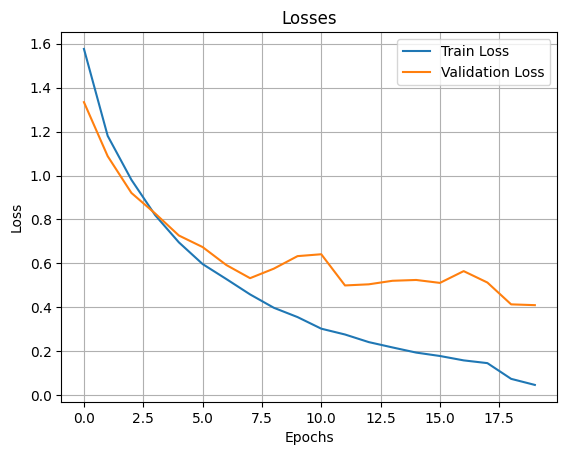

In [ ]:
# plot
plot_losses(tr_loss, vl_loss)

In [ ]:
mobilenet_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 86.98%


In [ ]:
# --- MobileNetV2 ---
in_channels= 3
num_classes= 10

model= MobileNetV2(mobilenetv2_configs, in_channels, num_classes).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()

# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

Number of parameters: 2236682
Using fused AdamW: True


In [ ]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.7766 | Val Loss: 1.5373 | dt/epoch: 80721.57ms
Epoch: 1 | Train Loss: 1.3435 | Val Loss: 1.1490 | dt/epoch: 80201.55ms
Epoch: 2 | Train Loss: 1.0740 | Val Loss: 0.9811 | dt/epoch: 80387.99ms
Epoch: 3 | Train Loss: 0.9182 | Val Loss: 0.9197 | dt/epoch: 80647.81ms
Epoch: 4 | Train Loss: 0.8096 | Val Loss: 0.7543 | dt/epoch: 80636.61ms
Epoch: 5 | Train Loss: 0.7292 | Val Loss: 0.6554 | dt/epoch: 80637.77ms
Epoch: 6 | Train Loss: 0.6591 | Val Loss: 0.6314 | dt/epoch: 80840.66ms
Epoch: 7 | Train Loss: 0.5923 | Val Loss: 0.5778 | dt/epoch: 80380.38ms
Epoch: 8 | Train Loss: 0.5580 | Val Loss: 0.5048 | dt/epoch: 80515.40ms
Epoch: 9 | Train Loss: 0.5064 | Val Loss: 0.5048 | dt/epoch: 81047.31ms
Epoch: 10 | Train Loss: 0.4777 | Val Loss: 0.5965 | dt/epoch: 81261.01ms
Epoch: 11 | Train Loss: 0.4465 | Val Loss: 0.4600 | dt/epoch: 80613.74ms
Epoch: 12 | Train Loss: 0.4158 | Val Loss: 0.4514 | dt/epoch: 80492.50ms
Epoch: 13 | Train Loss: 0.3869 | Val Loss: 0.4542 | dt/epoch:

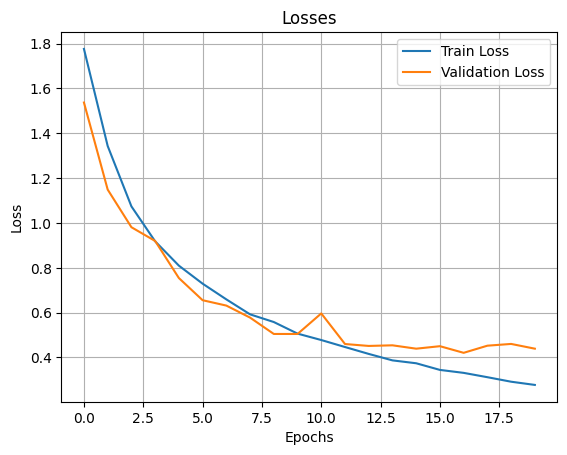

In [ ]:
# plot
plot_losses(tr_loss, vl_loss)

In [ ]:
mobilenet_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 85.24%


In [27]:
# --- MobileNetV3 ---
in_channels= 3
num_classes= 10

model= MobileNetV3(mobilenetv3_configs['mobilenetv3_large'], in_channels, num_classes).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()

# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

Number of parameters: 4214842
Using fused AdamW: True


In [28]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.5938 | Val Loss: 1.2495 | dt/epoch: 80758.89ms
Epoch: 1 | Train Loss: 1.0857 | Val Loss: 0.9077 | dt/epoch: 81239.48ms
Epoch: 2 | Train Loss: 0.8675 | Val Loss: 0.7581 | dt/epoch: 80771.62ms
Epoch: 3 | Train Loss: 0.7282 | Val Loss: 0.6465 | dt/epoch: 80667.55ms
Epoch: 4 | Train Loss: 0.6256 | Val Loss: 0.5504 | dt/epoch: 80228.33ms
Epoch: 5 | Train Loss: 0.5484 | Val Loss: 0.5136 | dt/epoch: 79341.23ms
Epoch: 6 | Train Loss: 0.4866 | Val Loss: 0.4597 | dt/epoch: 79940.46ms
Epoch: 7 | Train Loss: 0.4393 | Val Loss: 0.4620 | dt/epoch: 79450.20ms
Epoch: 8 | Train Loss: 0.4003 | Val Loss: 0.4741 | dt/epoch: 79506.53ms
Epoch: 9 | Train Loss: 0.3622 | Val Loss: 0.4032 | dt/epoch: 79702.43ms
Epoch: 10 | Train Loss: 0.3357 | Val Loss: 0.3823 | dt/epoch: 79496.59ms
Epoch: 11 | Train Loss: 0.3001 | Val Loss: 0.3736 | dt/epoch: 79191.75ms
Epoch: 12 | Train Loss: 0.2799 | Val Loss: 0.3942 | dt/epoch: 79428.33ms
Epoch: 13 | Train Loss: 0.2576 | Val Loss: 0.3848 | dt/epoch:

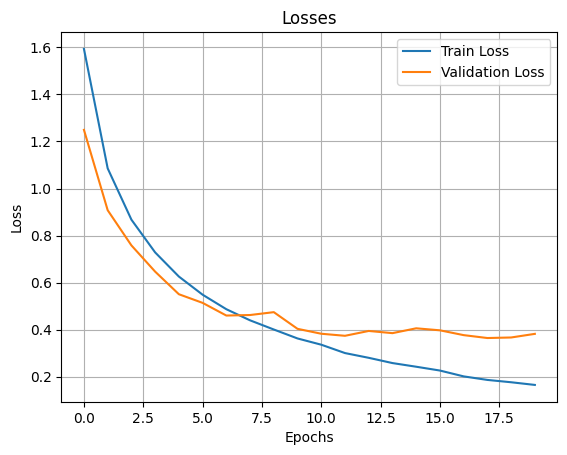

In [29]:
# plot
plot_losses(tr_loss, vl_loss)

In [30]:
mobilenet_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 88.36%
